# Design of Type Promotion Semantics for JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax/blob/main/docs/jep/9407-type-promotion.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax/blob/main/docs/jep/9407-type-promotion.ipynb)

*Jake VanderPlas, December 2021*

One of the challenges faced in the design of any numerical computing library is the choice of how to handle operations between values of different types. This document outlines the thought process behind the promotion semantics used by JAX, summarized in [JAX Type Promotion Semantics](https://docs.jax.dev/en/latest/type_promotion.html).

## Goals of JAX Type Promotion

JAX's numerical computing API is modeled after that of NumPy, with a few enhancements including the ability to target accelerators like GPU and TPU.
This makes adoption of NumPy's type promotion system disadvantageous for JAX users: NumPy’s type promotion rules heavily favor 64-bit outputs, which is problematic for computation on accelerators. Devices such as GPUs and TPUs often pay a significant performance penalty to use 64-bit floating point types, and in some cases do not support native 64-bit floating point types at all.

A simple example of this problematic type promotion semantics can be seen in binary operations between 32-bit integers and floats:

In [1]:
import numpy as np
np.dtype(np.int32(1) + np.float32(1))

dtype('float64')

NumPy's tendency to produce 64-bit values is a [long-standing issue](https://github.com/numpy/numpy/issues/6860) with using NumPy's API for accelerator computations, for which there isn't yet a good solution.
For this reason, JAX has sought to re-think NumPy-style type promotion with accelerators in mind.

## Stepping Back: Tables and Lattices

Before we dive into the details, let's take a moment to step back and think about *how* to think about the problem of type promotion. Consider arithmetic operations between built-in numerical types in Python, namely those of type `int`, `float`, and `complex`. With a few lines of code we can generate the type promotion table used by Python for addition between values of these types:

In [2]:
import pandas as pd
types = [int, float, complex]
name = lambda t: t.__name__
pd.DataFrame([[name(type(t1(1) + t2(1))) for t1 in types] for t2 in types],
             index=[name(t) for t in types], columns=[name(t) for t in types])

,int,float,complex
int,int,float,complex
float,float,float,complex
complex,complex,complex,complex


This table enumerates Python's numerical type promotion behavior, but it turns out there is a complementary representation that is much more compact: a [Lattice](https://en.wikipedia.org/wiki/Lattice_(order)) representation, where the [supremum](https://en.wikipedia.org/wiki/Infimum_and_supremum) between any two nodes is the type that they promote to. The lattice representation of Python's promotion table is much simpler:

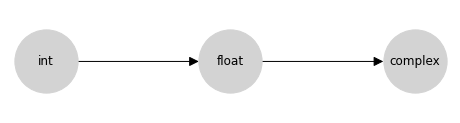

In [3]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {'int': ['float'], 'float': ['complex']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'int': [0, 0], 'float': [1, 0], 'complex': [2, 0]}
fig, ax = plt.subplots(figsize=(8, 2))
nx.draw(graph, with_labels=True, node_size=4000, node_color='lightgray', pos=pos, ax=ax, arrowsize=20)

This lattice is a compact encoding of the information in the promotion table above. You can find the result of a type promotion for two inputs by tracing the graph to the first common child of the two nodes (including the nodes themselves); mathematically, this common child is known as the *supremum*, or *least upper bound*, or *join* of the pair on the lattice; here we will refer to this operation as the **join**.

Conceptually, an arrow means that *implicit type promotion is allowed* between the source and the destination: for example, implicit promotion from integer to float is allowed, but implicit promotion from float to integer is not.

Keep in mind that in general not every directed acyclic graph (DAG) will satisfy the properties of a lattice. A lattice requires the existence of a unique least upper bound for every pair of nodes; so, for example the following two DAGs are not lattices:

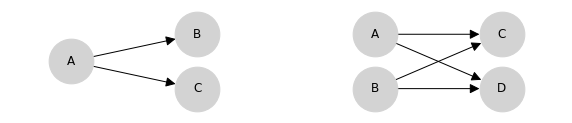

In [4]:
#@title
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 2))

lattice = {'A': ['B', 'C']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'A': [0, 0], 'B': [1, 0.5], 'C': [1, -0.5]}
nx.draw(graph, with_labels=True, node_size=2000, node_color='lightgray', pos=pos, ax=ax[0], arrowsize=20)
ax[0].set(xlim=[-0.5, 1.5], ylim=[-1, 1])

lattice = {'A': ['C', 'D'], 'B': ['C', 'D']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'A': [0, 0.5], 'B': [0, -0.5], 'C': [1, 0.5], 'D': [1, -0.5]}
nx.draw(graph, with_labels=True, node_size=2000, node_color='lightgray', pos=pos, ax=ax[1], arrowsize=20)
ax[1].set(xlim=[-0.5, 1.5], ylim=[-1, 1]);

The left DAG is not a lattice because there exists no upper bound for nodes `B` and `C`; the right DAG fails on two counts: first, there exists no upper bound for nodes `C` and `D`, and for nodes `A` and `B` the least upper bound cannot be *uniquely* determined: both `C` and `D` are candidates, but they are unorderable.

### Properties of a Type Promotion Lattice

Specifying type promotions in terms of a lattice ensures a number of useful properties. Denoting the join on the lattice with the $\vee$ operator, we have:

**Existence:** A lattice by definition requires that a unique lattice join exists for every pair of elements: $\forall (a, b): \exists !(a \vee b)$

**Commutativity:** The lattice join is commutative: $\forall (a, b): a\vee b = b \vee a$.

**Associativity:** The lattice join is associative: $\forall (a, b, c): a \vee (b \vee c) = (a \vee b) \vee c$.

On the other hand, these properties imply restrictions on the type promotion systems they can represent; in particular **not every type promotion table can be represented by a lattice**. A ready example of this is NumPy's full type promotion table; this can be shown quickly by counterexample: here are three scalar types whose promotion behavior in NumPy is non-associative:

In [5]:
import numpy as np
a, b, c = np.int8(1), np.uint8(1), np.float16(1)
print(np.dtype((a + b) + c))
print(np.dtype(a + (b + c)))

float32
float16


Such a result may come as a surprise to users: we generally expect mathematical expressions to map to mathematical concepts, so, for example, `a + b + c` should be equivalent to `c + b + a`; `x * (y + z)` should be equivalent to `x * y + x * z`. If type promotion is non-associative or non-commutative, these properties no longer apply.

Further, a lattice-based type promotion system is simpler to conceptualize and understand when compared to a table-based system. For example, JAX recognizes 18 distinct types: a promotion lattice consisting of 18 nodes and sparse, well-motivated connections between them is far easier to hold in one's mind than a table of 324 entries.

For this reason, we opt to use a lattice-based type promotion system for JAX.

## Type Promotion within Categories

Numerical computing libraries generally provide more than just `int`, `float`, and `complex`; within each of these categories there are a variety of possible precisions, denoted by the number of bits used in the numerical representation. The categories we will consider here are:

- *unsigned integers* which include `uint8`, `uint16`, `uint32` & `uint64` (we'll use `u8`, `u16`, `u32`, `u64` for short)
- *signed integers* which include `int8`, `int16`, `int32` & `int64` (we'll use `i8`, `i16`, `i32`, `i64` for short)
- *floating point*, which include `float16`, `float32` & `float64` (we'll use `f16`, `f32`, `f64` for short)
- *complex floating point*, which include `complex64` & `complex128` (we'll use `c64`, `c128` for short)

Numpy's type promotion semantics **within** each of these four categories is relatively straightforward: the ordered hierarchy of types translates directly to four separate lattices representing in-category type promotion rules:

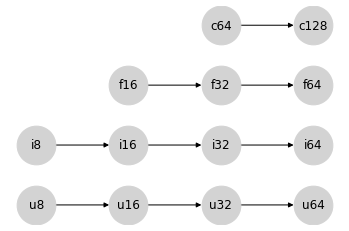

In [6]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'u8': [0, 0], 'u16': [1, 0], 'u32': [2, 0], 'u64': [3, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1, 2], 'f32': [2, 2], 'f64': [3, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

In terms of promotion of values to 64-bit that JAX seeks to avoid, these same-kind promotion semantics within each type category are unproblematic: the only way to produce a 64-bit output is to have a 64-bit input.

## Enter Python Scalars

Let's now think about where Python scalars fit into the mix.

In NumPy, promotion behavior differs depending on whether the inputs are arrays or scalars. For example, when operating on two scalars, normal promotion rules apply:

In [7]:
x = np.int8(0)  # int8 scalar
y = 1  # Python int = int64 scalar
(x + y).dtype

dtype('int64')

Here the Python value `1` is treated as an `int64`, and straightforward within-category rules lead to an `int64` result.

In operations between Python scalars and NumPy arrays, however, scalars defer to the dtype of the array. For example:

In [8]:
x = np.zeros(1, dtype='int8')  # int8 array
y = 1  # Python int = int64 scalar
(x + y).dtype

dtype('int8')

Here the bit width of the `int64` scalar is ignored, deferring to the bit width of the array.

There is another detail here: when NumPy type promotion involves a scalar, the output dtype is value-dependent: if the Python scalar is too large for the given dtype, it is promoted to a compatible type:

In [9]:
x = np.zeros(1, dtype='int8')  # int8 array
y = 1000  # int64 scalar
(x + y).dtype

dtype('int16')

For the purposes of JAX, **value-dependent promotion is a non-starter** because of the nature of JIT compilation and other transformations, which act on abstract representations of data without reference to their value.

Ignoring value-dependent effects, the signed integer branch of NumPy's type promotion can be represented in the following lattice, where we'll use `*` to mark scalar dtypes:

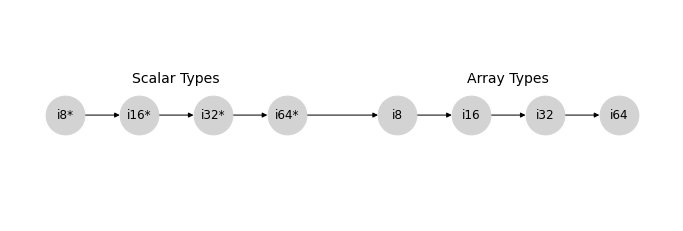

In [10]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i8*': ['i16*'], 'i16*': ['i32*'], 'i32*': ['i64*'], 'i64*': ['i8'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i8*': [0, 1], 'i16*': [2, 1], 'i32*': [4, 1], 'i64*': [6, 1],
  'i8': [9, 1], 'i16': [11, 1], 'i32': [13, 1], 'i64': [15, 1],
}
fig, ax = plt.subplots(figsize=(12, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)
ax.text(3, 1.6, "Scalar Types", ha='center', fontsize=14)
ax.text(12, 1.6, "Array Types", ha='center', fontsize=14)
ax.set_ylim(-1, 3);

A similar pattern holds within the `uint`, `float`, and `complex` lattices.

For the sake of simplicity, let's collapse each category of scalar types into a single node, denoted by `u*`, `i*`, `f*`, and `c*` respectively. Our set of in-category lattices can now be represented like this:

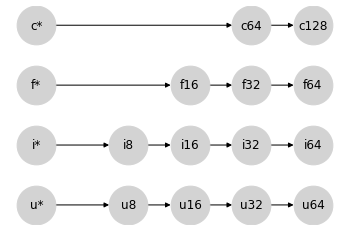

In [11]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'u*': ['u8'], 'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i*': ['i8'], 'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f*': ['f16'], 'f16': ['f32'], 'f32': ['f64'],
  'c*': ['c64'], 'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'u*': [0, 0], 'u8': [3, 0], 'u16': [5, 0], 'u32': [7, 0], 'u64': [9, 0],
  'i*': [0, 1], 'i8': [3, 1], 'i16': [5, 1], 'i32': [7, 1], 'i64': [9, 1],
  'f*': [0, 2], 'f16': [5, 2], 'f32': [7, 2], 'f64': [9, 2],
  'c*': [0, 3], 'c64': [7, 3], 'c128': [9, 3],
}
fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

In some senses, putting scalars at the left is a strange choice: the scalar types may contain values of any width, but when interacting with an array of a given type, the promotion result defers to the array type.
The benefit of this is that when you perform an operation like `x + 2` for an array `x`, the type of `x` will carry to the result no matter its width:

In [12]:
for dtype in [np.int8, np.int16, np.int32, np.int64]:
  x = np.arange(10, dtype=dtype)
  assert (x + 2).dtype == dtype

This behavior gives motivation to our `*` notation for scalar values: the `*` is reminiscent of a wildcard that can take on any desired value.

The benefit of these semantics is that you can readily express sequences of operations with clean Python code, without having to explicitly cast scalars to the appropriate type. Imagine if rather than writing this:
```python
3 * (x + 1) ** 2
```
you had to write this:
```python
np.int32(3) * (x + np.int32(1)) ** np.int32(2)
```
Although it is explicit, numerical code would become tedious to read or write. With the scalar promotion semantics described above, given an array `x` of type `int32`, the types in the second statement are implicit within the first.

## Combining Lattices

Recall that we began our discussion by introducing the lattice representing type promotion within Python: `int -> float -> complex`. Let's rewrite this as `i* -> f* -> c*`, and let's further allow `i*` to subsume `u*` (after all, there is no unsigned integer scalar type in Python).

Putting these all together, we get the following partial lattice representing type promotion between Python scalars and numpy arrays:

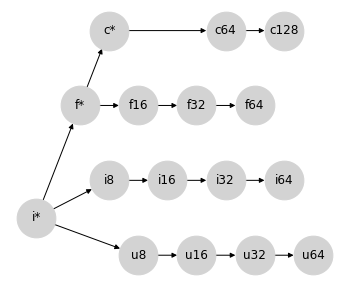

In [13]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

Notice that this is not (yet) a true lattice: there are many pairs of nodes for which a join does not exist. However, we can think of this as a *partial* lattice, in which some pairs of nodes do not have a defined promotion behavior, and the defined portion of this partial lattice does correctly describe NumPy's array promotion behavior (leaving aside value-dependent semantics mentioned above).

This sets up a nice framework by which we can think about filling-out these undefined promotion rules, by adding connections on this graph. But which connections to add?
Broadly speaking, we want any additional connections to satisfy a few properties:

1. Promotion should satisfy the commutative and associative properties: in other words, the graph should remain a (partial) lattice.

2. Promotion should never allow for dropping entire components of data: for example, we should never promote `complex` to `float`, as it would discard any imaginary parts.

3. Promotion should never lead to an unhandled overflow. For example, the maximum possible `uint32` is twice as large as the maximum possible `int32`, so we should not implicitly promote `uint32` to `int32`. 

4. Wherever possible, promotion should avoid loss of precision. For example, an `int64` value may have 64 bits of mantissa, so promoting `int64` to `float64` represents a possible loss of precision. However, the maximum representable float64 is larger than the maximum representable int64, so in this case criterion #3 is still satisfied.

5. Wherever possible, binary promotion should avoid resulting in types that are wider than the inputs. This is to ensure that JAX's implicit promotions remain friendly to accelerator-based workflows, in which users often want to restrict types to 32-bit (or in some cases 16-bit) values.

Each new connection on the lattice introduces some level of convenience to the user (a new set of types that can interact without explicit casting), but the convenience may become too costly if any of the above criteria are violated. Developing a full promotion lattice involves striking a balance between this convenience and this cost.

## Mixed Promotion: Float and Complex

Let's begin with what is perhaps the easiest case, that of promotion between float and complex values.

Complex numbers are made up of pairs of floating point numbers, and so we have a natural path of promotion between them: cast float to complex while maintaining the width of the real part. In terms of our partial lattice representation, it would look like this:

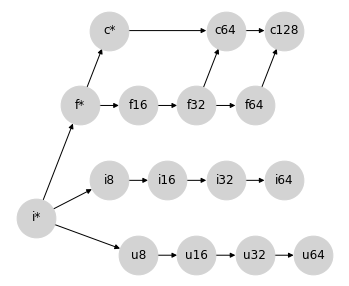

In [14]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

This turns out to represent exactly the semantics used by Numpy in mixed float/complex type promotion.

## Mixed Promotion: Signed & Unsigned Integers

For the next case, let's consider something a bit more difficult: promotion between signed and unsigned integers. For example, when promoting `uint8` to a signed integer, how many bits do we need?

At first glance, you might think it natural to promote `uint8` to `int8`; but the largest `uint8` numbers are not representable in `int8`. For this reason, it makes more sense to promote unsigned integers to integers with twice the number of bits; this promotion behavior can be represented by adding the following connections to the promotion lattice:

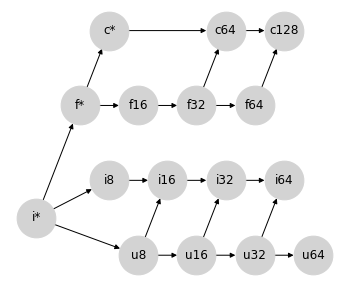

In [15]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

Again, the connections added here are precisely the promotion semantics implemented by Numpy for mixed-integer promotion.

### How to handle `uint64`?

The approach to mixed signed/unsigned integer promotion leaves out one type: `uint64`. Following the pattern above, the output of a mixed-integer operation involving `uint64` should result in `int128`, but this is not a standard available dtype.

Numpy's choice here is to promote to `float64`:

In [16]:
(np.uint64(1) + np.int64(1)).dtype

dtype('float64')

However, this may be a surprising convention: it's the only case in which promotion of integer types does not result in an integer.
For now, we will leave `uint64` promotion undefined, and return to it later.

## Mixed Promotion: Integer and Floating

When promoting integers to floating point, we might start with the same thought process as mixed promotion between signed and unsigned integers. A 16-bit signed or unsigned integer cannot be represented at full precision by a 16-bit float, which has only 10 bits of mantissa. Therefore, it might make sense to promote integers to floats represented by twice the number of bits:

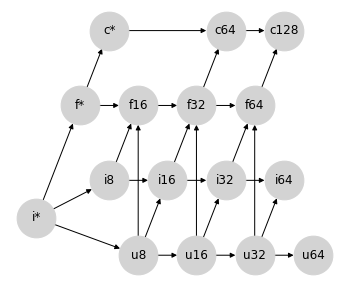

In [17]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16', 'f16'], 'u16': ['u32', 'i32', 'f32'], 'u32': ['u64', 'i64', 'f64'],
  'i8': ['i16', 'f16'], 'i16': ['i32', 'f32'], 'i32': ['i64', 'f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

This is effectively what Numpy type promotion does, but in doing so it breaks the lattice property of the graph: for example, the pair *{i8, u8}* no longer has a unique least upper bound: the possibilities are *i16* and *f16*, which are unorderable on the graph. This turns out to be the source of NumPy's non-associative type promotion highlighted above.

Can we come up with a modification of NumPy's promotion rules, such that it will satisfy the lattice property, while also giving sensible results for mixed type promotion? There are a few approaches we could take here.

### Option 0: Leave integer/floating mixed precision undefined

To make behavior utterly predictable (at some cost to user convenience), a defensible choice would be to leave as undefined any mixed integer/float promotion beyond Python scalars, stopping with the partial lattice from the previous section. The downside would be the requirement for users to explicitly type-cast when operating between integer and floating-point quantities.

### Option 1: Avoiding All Precision Loss

If our focus is on avoiding precision loss at all costs, we can restore the lattice property by promoting unsigned integers to float via their existing signed integer paths:

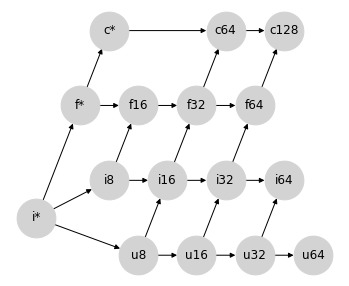

In [18]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16', 'f16'], 'i16': ['i32', 'f32'], 'i32': ['i64', 'f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

A disadvantage of this approach is that it still leaves `int64` and `uint64` promotion undefined, because there is no standard floating point type with enough bits of mantissa to represent their full range of values. We could relax the precision constraint and complete the lattice by drawing connections from `i64->f64` and `u64->f64`, but those links would run counter to the motivation for this promotion scheme.

A second disadvantage is that this lattice makes it difficult to find a sensible place to insert `bfloat16` (see below) while maintaining the lattice property.

A third disadvantage of this approach, more important for JAX's accelerator backends, is that some operations result in types that are much wider than necessary; for example mixed operations between `uint16` and `float16` would promote all the way to `float64`, which is not ideal.

### Option 2: Avoid most wider-than-necessary promotions

To address the unnecessary promotions to wider types, we could accept the possibility of some precision loss in integer/float promotion, promoting signed integers to floats of the same width:

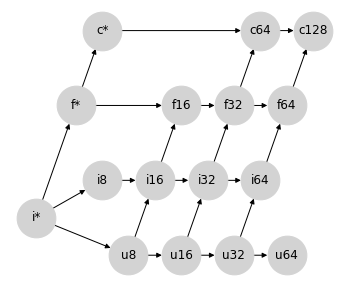

In [19]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['f16', 'i32'], 'i32': ['f32', 'i64'], 'i64': ['f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.5, 2], 'f32': [2.5, 2], 'f64': [3.5, 2],
  'c64': [3, 3], 'c128': [4, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

While this does allow for precision-losing promotions between integers and floats, these promotions will not mis-represent the *magnitude* of the result: though the floating point mantissa is not wide enough to represent all values, the exponent is wide enough to approximate them.

This approach also allows a natural promotion path from `int64` to `float64`, though `uint64` remains unpromotable in this scheme. That said, a connection from `u64` to `f64` could be justified more readily here than before.

This promotion scheme still results in some wider than necessary promotion paths; for example operations between `float32` and `uint32` result in `float64`. Additionally, this lattice makes it difficult to find a sensible place to insert `bfloat16` (see below) while maintaining the lattice property.

### Option 3: Avoid all wider-than-necessary promotions

We can avoid *all* non-ideal 64-bit promotions if we're willing to fundamentally change our thinking around integer and float promotions.
Just as scalars always defer to the widths of array types, we can make integers always defer to the width of float types:

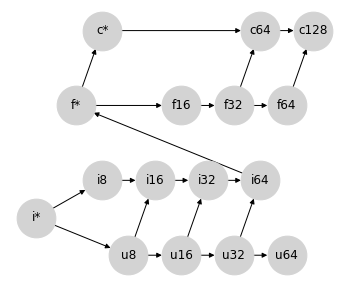

In [20]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.5, 2], 'f32': [2.5, 2], 'f64': [3.5, 2],
  'c64': [3, 3], 'c128': [4, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

This involves a small sleight of hand: previously we had used `f*` to refer to a scalar type. In this lattice, `f*` might be applied to the array output of a mixed computation. Instead of thinking of `f*` as a scalar, we could think of it as a special kind of `float` value with distinct promotion rules: in JAX we refer to this as a *weak float*; see below.

The advantage of this approach is that, outside unsigned ints, it avoids *all* wider-than-necessary promotions: you can never get an f64 output without a 64-bit input, and you can never get an f32 output without a 32-bit input: this results in convenient semantics for working on accelerators while avoiding inadvertent 64-bit values.

This feature of giving primacy to floating point types resembles the type promotion behavior of PyTorch.
This lattice also happens to generate a promotion table that very closely resembles JAX's original *ad hoc* type promotion scheme, which was not based on a lattice but had the property of giving primacy to floating point types.

This lattice additionally offers a natural location to insert `bfloat16`, without the need to impose an ordering between `bf16` and `f16`:

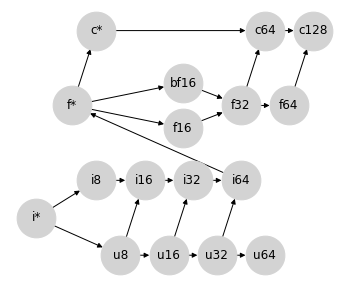

In [21]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16', 'bf16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'bf16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.8, 1.7], 'bf16': [1.8, 2.3], 'f32': [3.0, 2], 'f64': [4.0, 2],
  'c64': [3.5, 3], 'c128': [4.5, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)

This is important because `f16` and `bf16` are not comparable because they utilize their bits differently: `bf16` represents a larger range at lower precision, while `f16` represents a smaller range at higher precision.

However, these advantages comes with a few tradeoffs:

- mixed float/integer promotion is very prone to precision loss: for example, `int64` (with a maximum value of $9.2 \times 10^{18}$) can be promoted to `float16` (with a maximum value of $6.5 \times 10^4$), meaning most representable values will become `inf`.
- as mentioned above, `f*` can no longer be thought of as a "scalar type", but as a different flavor of float64. In JAX's parlance, this is referred to as a [*weak type*](https://docs.jax.dev/en/latest/type_promotion.html#weakly-typed-values-in-jax), in that it is represented as 64-bit, but only weakly holds to this bit width in promotion with other values.

Note that also, this approach still leaves the `uint64` promotion question unanswered, although it is perhaps reasonable to close the lattice by connecting `u64` to `f*`.

## Type Promotion in JAX

In designing the type promotion semantics of JAX, we kept in mind many of these ideas, and leaned heavily on a few things:

1. We chose to constrain JAX's type promotion semantics to graphs that satisfy the lattice property: this is to ensure associativity and commutativity, but also to allow the semantics to be compactly described in a DAG, rather than requiring a large table.

2. We leaned toward semantics that avoid inadvertent promotion to wider types, particularly when it comes to float values, in order to benefit computation on accelerators.

3. We were fine accepting potential loss of precision (but not loss of magnitude) in mixed type promotion if it were required to maintain (1) and (2)

With this in mind, JAX has adopted Option 3. Or rather, a slightly modified version of Option 3 that draws the connection between `u64` and `f*`, in order to create a true lattice.
Rearranging the nodes for clarity, JAX's type promotion lattice then looks like this:

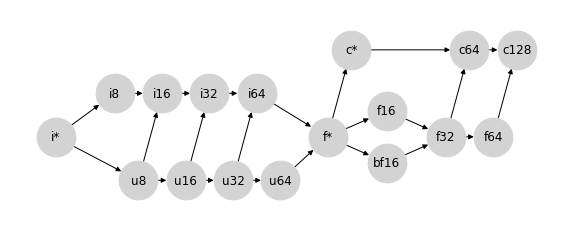

In [22]:
#@title
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16', 'bf16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'], 'u64': ['f*'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'bf16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [4.5, 0.5], 'c*': [5, 1.5],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [5.75, 0.8], 'bf16': [5.75, 0.2], 'f32': [7, 0.5], 'f64': [8, 0.5],
  'c64': [7.5, 1.5], 'c128': [8.5, 1.5],
}
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylim(-0.5, 2)
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)
# ax.patches[12].set_linestyle((0, (2, 4)))

The behavior resulting from this choice is summarized in [JAX Type Promotion Semantics](https://docs.jax.dev/en/latest/type_promotion.html). Notably, aside from the inclusion of larger unsigned types (`u16`, `u32`, `u64`) and some details about the behavior of scalar/weak types (`i*`, `f*`, `c*`), this type promotion scheme turns out to be very close to that chosen by PyTorch.

For those interested, the appendix below prints the full promotion tables used by NumPy, Tensorflow, PyTorch, and JAX.

## Appendix: Example Type Promotion Tables

The following are some examples of implicit type promotion tables implemented by various Python array computing libraries.

### NumPy Type Promotion

Note that NumPy does not include the `bfloat16` dtype, and that the table below ignores value-dependent effects.

In [1]:
# @title

import numpy as np
import pandas as pd
from IPython import display

np_dtypes = {
  'b': np.bool_,
  'u8': np.uint8, 'u16': np.uint16, 'u32': np.uint32, 'u64': np.uint64,
  'i8': np.int8, 'i16': np.int16, 'i32': np.int32, 'i64': np.int64,
  'bf16': 'invalid', 'f16': np.float16, 'f32': np.float32, 'f64': np.float64,
  'c64': np.complex64, 'c128': np.complex128,
  'i*': int, 'f*': float, 'c*': complex}

np_dtype_to_code = {val: key for key, val in np_dtypes.items()}

def make_np_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return np.zeros(1, dtype=dtype)

def np_result_code(dtype1, dtype2):
  try:
    out = np.add(make_np_zero(dtype1), make_np_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return np_dtype_to_code[type(out)]
    else:
      return np_dtype_to_code[out.dtype.type]


grid = [[np_result_code(dtype1, dtype2)
         for dtype2 in np_dtypes.values()]
        for dtype1 in np_dtypes.values()]
table = pd.DataFrame(grid, index=np_dtypes.keys(), columns=np_dtypes.keys())
display.HTML(table.to_html())

,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
b,b,u8,u16,u32,u64,i8,i16,i32,i64,-,f16,f32,f64,c64,c128,i64,f64,c128
u8,u8,u8,u16,u32,u64,i16,i16,i32,i64,-,f16,f32,f64,c64,c128,u8,f64,c128
u16,u16,u16,u16,u32,u64,i32,i32,i32,i64,-,f32,f32,f64,c64,c128,u16,f64,c128
u32,u32,u32,u32,u32,u64,i64,i64,i64,i64,-,f64,f64,f64,c128,c128,u32,f64,c128
u64,u64,u64,u64,u64,u64,f64,f64,f64,f64,-,f64,f64,f64,c128,c128,u64,f64,c128
i8,i8,i16,i32,i64,f64,i8,i16,i32,i64,-,f16,f32,f64,c64,c128,i8,f64,c128
i16,i16,i16,i32,i64,f64,i16,i16,i32,i64,-,f32,f32,f64,c64,c128,i16,f64,c128
i32,i32,i32,i32,i64,f64,i32,i32,i32,i64,-,f64,f64,f64,c128,c128,i32,f64,c128
i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,-,f64,f64,f64,c128,c128,i64,f64,c128
bf16,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


### Tensorflow Type Promotion

Tensorflow avoids defining implicit type promotion, except for Python scalars in limited cases. The table is asymmetric because in `tf.add(x, y)`, the type of `y` must be coercible to the type of `x`.

In [23]:
# @title

import tensorflow as tf
import pandas as pd
from IPython import display

tf_dtypes = {
  'b': tf.bool,
  'u8': tf.uint8, 'u16': tf.uint16, 'u32': tf.uint32, 'u64': tf.uint64,
  'i8': tf.int8, 'i16': tf.int16, 'i32': tf.int32, 'i64': tf.int64,
  'bf16': tf.bfloat16, 'f16': tf.float16, 'f32': tf.float32, 'f64': tf.float64,
  'c64': tf.complex64, 'c128': tf.complex128,
  'i*': int, 'f*': float, 'c*': complex}

tf_dtype_to_code = {val: key for key, val in tf_dtypes.items()}

def make_tf_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return tf.zeros(1, dtype=dtype)

def result_code(dtype1, dtype2):
  try:
    out = tf.add(make_tf_zero(dtype1), make_tf_zero(dtype2))
  except (TypeError, tf.errors.InvalidArgumentError):
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return tf_dtype_to_code[type(out)]
    else:
      return tf_dtype_to_code[out.dtype]


grid = [[result_code(dtype1, dtype2)
         for dtype2 in tf_dtypes.values()]
        for dtype1 in tf_dtypes.values()]
table = pd.DataFrame(grid, index=tf_dtypes.keys(), columns=tf_dtypes.keys())
display.HTML(table.to_html())

,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
b,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u8,-,u8,-,-,-,-,-,-,-,-,-,-,-,-,-,u8,-,-
u16,-,-,u16,-,-,-,-,-,-,-,-,-,-,-,-,u16,-,-
u32,-,-,-,u32,-,-,-,-,-,-,-,-,-,-,-,u32,-,-
u64,-,-,-,-,u64,-,-,-,-,-,-,-,-,-,-,u64,-,-
i8,-,-,-,-,-,i8,-,-,-,-,-,-,-,-,-,i8,-,-
i16,-,-,-,-,-,-,i16,-,-,-,-,-,-,-,-,i16,-,-
i32,-,-,-,-,-,-,-,i32,-,-,-,-,-,-,-,i32,-,-
i64,-,-,-,-,-,-,-,-,i64,-,-,-,-,-,-,i64,-,-
bf16,-,-,-,-,-,-,-,-,-,bf16,-,-,-,-,-,bf16,bf16,-


### PyTorch Type Promotion

Notice that torch does not include unsigned integer types larger than `uint8`.
Aside from this and some details about promotion with scalar/weak types, the table is close to that used by `jax.numpy`.

In [3]:
# @title
import torch
import pandas as pd
from IPython import display

torch_dtypes = {
  'b': torch.bool,
  'u8': torch.uint8, 'u16': 'invalid', 'u32': 'invalid', 'u64': 'invalid',
  'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64,
  'bf16': torch.bfloat16, 'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64,
  'c64': torch.complex64, 'c128': torch.complex128,
  'i*': int, 'f*': float, 'c*': complex}

torch_dtype_to_code = {val: key for key, val in torch_dtypes.items()}

def make_torch_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return torch.zeros(1, dtype=dtype)

def torch_result_code(dtype1, dtype2):
  try:
    out = torch.add(make_torch_zero(dtype1), make_torch_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return torch_dtype_to_code[type(out)]
    else:
      return torch_dtype_to_code[out.dtype]


grid = [[torch_result_code(dtype1, dtype2)
         for dtype2 in torch_dtypes.values()]
        for dtype1 in torch_dtypes.values()]
table = pd.DataFrame(grid, index=torch_dtypes.keys(), columns=torch_dtypes.keys())
display.HTML(table.to_html())

,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
b,b,u8,-,-,-,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i64,f32,c64
u8,u8,u8,-,-,-,i16,i16,i32,i64,bf16,f16,f32,f64,c64,c128,u8,f32,c64
u16,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u32,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u64,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
i8,i8,i16,-,-,-,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i8,f32,c64
i16,i16,i16,-,-,-,i16,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i16,f32,c64
i32,i32,i32,-,-,-,i32,i32,i32,i64,bf16,f16,f32,f64,c64,c128,i32,f32,c64
i64,i64,i64,-,-,-,i64,i64,i64,i64,bf16,f16,f32,f64,c64,c128,i64,f32,c64
bf16,bf16,bf16,-,-,-,bf16,bf16,bf16,bf16,bf16,f32,f32,f64,c64,c128,bf16,bf16,c64


### JAX Type Promotion: `jax.numpy`

`jax.numpy` follows type promotion rules laid out at https://docs.jax.dev/en/latest/type_promotion.html. Here we use `i*`, `f*`, `c*` to indicate both Python scalars and weakly-typed arrays.

In [26]:
# @title
import jax
import jax.numpy as jnp
import pandas as pd
from IPython import display
jax.config.update('jax_enable_x64', True)

jnp_dtypes = {
  'b': jnp.bool_.dtype,
  'u8': jnp.uint8.dtype, 'u16': jnp.uint16.dtype, 'u32': jnp.uint32.dtype, 'u64': jnp.uint64.dtype,
  'i8': jnp.int8.dtype, 'i16': jnp.int16.dtype, 'i32': jnp.int32.dtype, 'i64': jnp.int64.dtype,
  'bf16': jnp.bfloat16.dtype, 'f16': jnp.float16.dtype, 'f32': jnp.float32.dtype, 'f64': jnp.float64.dtype,
  'c64': jnp.complex64.dtype, 'c128': jnp.complex128.dtype,
  'i*': int, 'f*': float, 'c*': complex}


jnp_dtype_to_code = {val: key for key, val in jnp_dtypes.items()}

def make_jnp_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return jnp.zeros((), dtype=dtype)

def jnp_result_code(dtype1, dtype2):
  try:
    out = jnp.add(make_jnp_zero(dtype1), make_jnp_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if hasattr(out, 'aval') and out.aval.weak_type:
      return out.dtype.kind + '*'
    elif type(out) in {int, float, complex}:
      return jnp_dtype_to_code[type(out)]
    else:
      return jnp_dtype_to_code[out.dtype]

grid = [[jnp_result_code(dtype1, dtype2)
         for dtype2 in jnp_dtypes.values()]
        for dtype1 in jnp_dtypes.values()]
table = pd.DataFrame(grid, index=jnp_dtypes.keys(), columns=jnp_dtypes.keys())
display.HTML(table.to_html())

,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
b,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
u8,u8,u8,u16,u32,u64,i16,i16,i32,i64,bf16,f16,f32,f64,c64,c128,u8,f*,c*
u16,u16,u16,u16,u32,u64,i32,i32,i32,i64,bf16,f16,f32,f64,c64,c128,u16,f*,c*
u32,u32,u32,u32,u32,u64,i64,i64,i64,i64,bf16,f16,f32,f64,c64,c128,u32,f*,c*
u64,u64,u64,u64,u64,u64,f*,f*,f*,f*,bf16,f16,f32,f64,c64,c128,u64,f*,c*
i8,i8,i16,i32,i64,f*,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i8,f*,c*
i16,i16,i16,i32,i64,f*,i16,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i16,f*,c*
i32,i32,i32,i32,i64,f*,i32,i32,i32,i64,bf16,f16,f32,f64,c64,c128,i32,f*,c*
i64,i64,i64,i64,i64,f*,i64,i64,i64,i64,bf16,f16,f32,f64,c64,c128,i64,f*,c*
bf16,bf16,bf16,bf16,bf16,bf16,bf16,bf16,bf16,bf16,bf16,f32,f32,f64,c64,c128,bf16,bf16,c64


### JAX Type Promotion: `jax.lax`
`jax.lax` is lower-level, and does not do any implicit promotion. Here we use `i*`, `f*`, `c*` to indicate both Python scalars and weakly-typed arrays.

In [5]:
# @title
import jax
import jax.numpy as jnp
import pandas as pd
from IPython import display
jax.config.update('jax_enable_x64', True)

jnp_dtypes = {
  'b': jnp.bool_.dtype,
  'u8': jnp.uint8.dtype, 'u16': jnp.uint16.dtype, 'u32': jnp.uint32.dtype, 'u64': jnp.uint64.dtype,
  'i8': jnp.int8.dtype, 'i16': jnp.int16.dtype, 'i32': jnp.int32.dtype, 'i64': jnp.int64.dtype,
  'bf16': jnp.bfloat16.dtype, 'f16': jnp.float16.dtype, 'f32': jnp.float32.dtype, 'f64': jnp.float64.dtype,
  'c64': jnp.complex64.dtype, 'c128': jnp.complex128.dtype,
  'i*': int, 'f*': float, 'c*': complex}


jnp_dtype_to_code = {val: key for key, val in jnp_dtypes.items()}

def make_jnp_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return jnp.zeros((), dtype=dtype)

def jnp_result_code(dtype1, dtype2):
  try:
    out = jax.lax.add(make_jnp_zero(dtype1), make_jnp_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if hasattr(out, 'aval') and out.aval.weak_type:
      return out.dtype.kind + '*'
    elif type(out) in {int, float, complex}:
      return jnp_dtype_to_code[type(out)]
    else:
      return jnp_dtype_to_code[out.dtype]

grid = [[jnp_result_code(dtype1, dtype2)
         for dtype2 in jnp_dtypes.values()]
        for dtype1 in jnp_dtypes.values()]
table = pd.DataFrame(grid, index=jnp_dtypes.keys(), columns=jnp_dtypes.keys())
display.HTML(table.to_html())

,b,u8,u16,u32,u64,i8,i16,i32,i64,bf16,f16,f32,f64,c64,c128,i*,f*,c*
b,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u8,-,u8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u16,-,-,u16,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u32,-,-,-,u32,-,-,-,-,-,-,-,-,-,-,-,-,-,-
u64,-,-,-,-,u64,-,-,-,-,-,-,-,-,-,-,-,-,-
i8,-,-,-,-,-,i8,-,-,-,-,-,-,-,-,-,-,-,-
i16,-,-,-,-,-,-,i16,-,-,-,-,-,-,-,-,-,-,-
i32,-,-,-,-,-,-,-,i32,-,-,-,-,-,-,-,-,-,-
i64,-,-,-,-,-,-,-,-,i64,-,-,-,-,-,-,i64,-,-
bf16,-,-,-,-,-,-,-,-,-,bf16,-,-,-,-,-,-,-,-
